In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import seaborn as sns

In [39]:
indian_df = pd.read_csv('../Data/Indian ATM preprocessed.csv')

In [40]:
def get_new_df(df):

    df['Predicted by Lower'] = np.abs(df['Predicted'] - df['Lower Bound']) / np.abs(df['Lower Bound'] )
    df['Original by Lower'] = np.abs(df['Original'] - df['Lower Bound']) / np.abs(df['Lower Bound']) 
    c1 = df['Original'] < df['Lower Bound']
    ind = df[c1].index


    c2 = (df['Lower Bound'] < 0)
    ind1 = df.loc[c2, :].index
    ind2 = df.loc[~c2, :].index
    
    X_test = df.loc[ind1, ['Original', 'Upper Bound']]
    X_train = df.loc[ind2, ['Original', 'Upper Bound']]
    y_train = df.loc[ind2, 'Lower Bound']
    
    if len(X_test) > 0:
        
            rf = RandomForestRegressor()
            rf.fit(X_train, y_train)
            rf_pred = rf.predict(X_test)
            
            knn = KNeighborsRegressor(n_neighbors=3, weights = 'distance', )
            knn.fit(X_train, y_train)
            knn_pred = knn.predict(X_test)
            
            lgbm_reg = lgb.LGBMRegressor(verbosity=-1, objective= 'regression_l2', metric='mse')
            lgbm_reg.fit(X_train, y_train)
            lgbm_pred = lgbm_reg.predict(X_test)
            
            lower_bound = np.mean([lgbm_pred, knn_pred, rf_pred], axis=0)
            df.loc[ind1, 'Lower Bound'] = lower_bound


    c3 = df['Predicted'] < 0
    ind1 = df.loc[c3, :].index
    ind2 = df.loc[~c3, :].index
    
    X_test = df.loc[ind1, ['Original', 'Upper Bound', 'Lower Bound']]
    X_train = df.loc[ind2, ['Original', 'Upper Bound', 'Lower Bound']]
    y_train = df.loc[ind2, 'Predicted']
    
    if len(X_test) > 0:
    
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        
        knn = KNeighborsRegressor(n_neighbors=3, weights = 'distance', )
        knn.fit(X_train, y_train)
        knn_pred = knn.predict(X_test)
        
        lgbm_reg = lgb.LGBMRegressor(verbosity=-1, objective= 'regression_l2', metric='mse')
        lgbm_reg.fit(X_train, y_train)
        lgbm_pred = lgbm_reg.predict(X_test)
        
        pred = np.mean([lgbm_pred, knn_pred, rf_pred], axis=0)
        df.loc[ind1, 'Predicted'] = pred


    
    c4 = df['Original'] < df['Lower Bound']
    df.loc[c4 & ~c1, 'Lower Bound'] = df.loc[c4 & ~c1, 'Original'] / (1 + df.loc[c4 & ~c1, 'Original by Lower'])


    c5 = df['Predicted'] < df['Lower Bound']
    df.loc[c5 & ~c1, 'Lower Bound'] = df.loc[c5 & ~c1, 'Predicted'] / (1 + df.loc[c5 & ~c1, 'Predicted by Lower'])

    return df

In [41]:
def get_picp_mpiw(df):

    picp = 1 - np.sum(df['Outcome']) / len(df)
    mpiw = np.mean(df['Upper Bound'] - df['Lower Bound'])

    return picp, mpiw

In [42]:
def plot(y_train, y_test, lower_bound, upper_bound, name):

    test_len = 100
    train_len = len(y_train) - 300
    X_axis = range(train_len + test_len)

    plt.figure(figsize=(20,8))

    plt.fill_between(
        range(300, 400),
        lower_bound.flatten()[:test_len],
        upper_bound.flatten()[:test_len],
        color="orange",
        alpha=0.9,
        label="Prediction Interval",
        zorder=1
    )

    plt.plot(range(300), y_train[train_len:], color='blue', zorder=2, label = 'Original Values (Train)')
    plt.plot(range(300, 400), y_test[:test_len], color='blue', zorder=2, ls='--', label = 'Original Values (Test)')


    plt.legend(loc='upper left')
    plt.xlabel("Timeline")
    plt.ylabel("Amount")
    plt.title(f"Prediction Intervals (PIs) using {name}")
    plt.show()


In [43]:
def plot_range(y_test, lower_bound, upper_bound, name):

    y_test = np.array(y_test).flatten() 
    lower_bound = np.array(lower_bound).flatten() 
    upper_bound = np.array(upper_bound).flatten()

    c1 = (y_test < upper_bound) & (y_test > lower_bound)
    
    plt.figure(figsize = (15,6))
    test_len = len(y_test)

    df = pd.DataFrame({
        'Timeline': list(range(100)),
        'Lower Bound': lower_bound[test_len - 100: test_len],
        'Original': y_test[test_len - 100: test_len],
        'Upper Bound': upper_bound[test_len - 100: test_len]
    })

    sns.lineplot(data = df, x = 'Timeline', y = 'Lower Bound', label = 'Lower Bound')
    sns.lineplot(data = df, x = 'Timeline', y = 'Original', label = 'Original Values (Test)')
    sns.lineplot(data = df, x = 'Timeline', y = 'Upper Bound', label = 'Upper Bound')
    
    plt.legend()
    plt.xlabel('Timeline')
    plt.ylabel('Amount')
    plt.title(f"Prediction Intervals (PIs) using {name}")
    plt.legend(loc='upper left')
    plt.show()
    print()
    

## QD Loss

In [44]:
qd_df = pd.read_csv('../Results/Results_QD 2.csv')

In [45]:
qd_df['Outcome'].value_counts(normalize=True)

0    0.959763
1    0.040237
Name: Outcome, dtype: float64

In [46]:
new_qd = get_new_df(qd_df)

In [47]:
a = get_picp_mpiw(new_qd)
print('\nPICP: ', a[0])
print('MPIW: ', a[1], '\n')


PICP:  0.9597633136094674
MPIW:  247356.81250756572 



In [48]:
tr = int(len(indian_df) * 0.8)

y = indian_df.iloc[:, 32]

y_train_qd, y_test_qd = y[:tr], y[tr:]

C:\Users\HP\AppData\Local\Temp\ipykernel_11368\2898526384.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(range(300, 400), y_test[:test_len], color='blue', zorder=2, ls='--', label = 'Original Values (Test)')


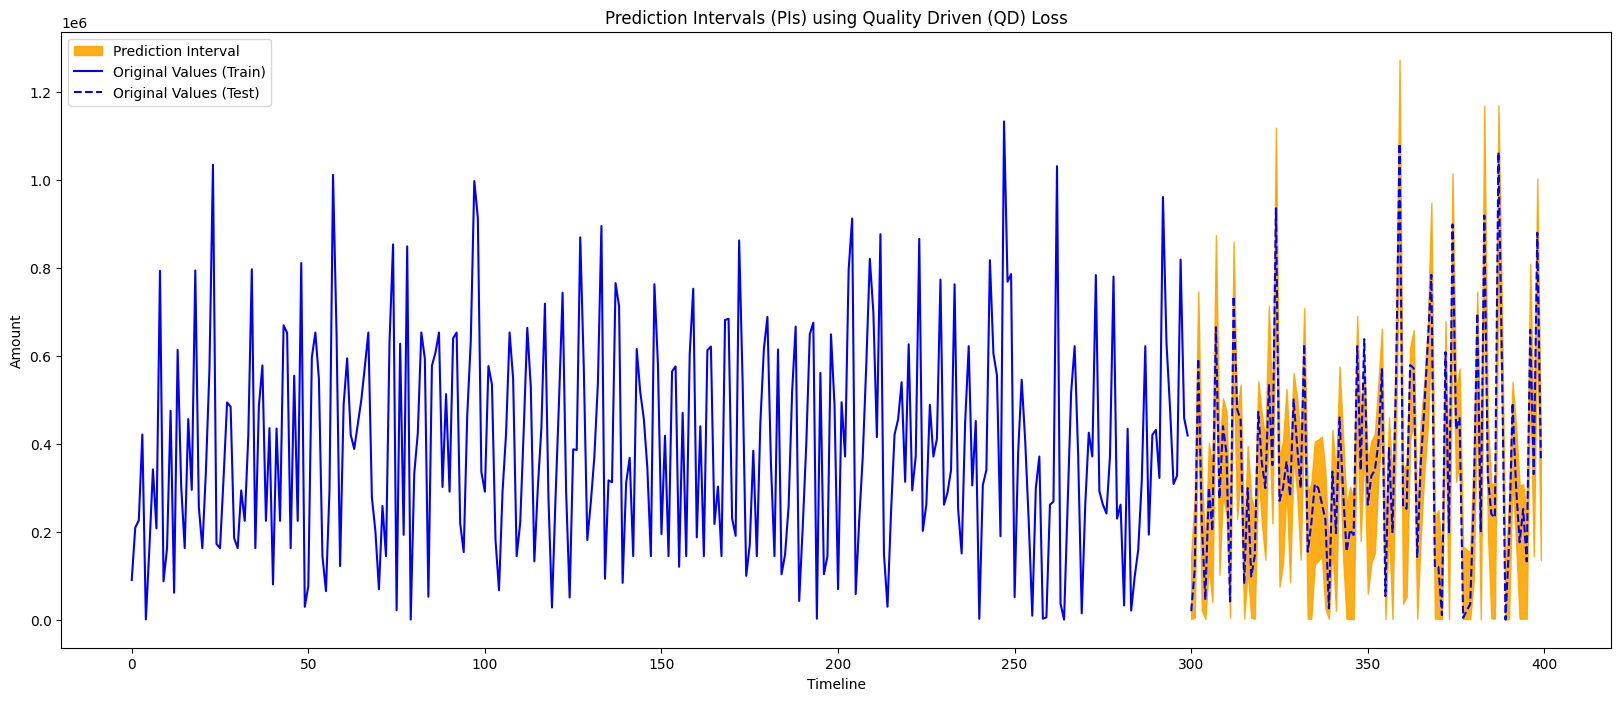

In [49]:
lb_qd = np.array(new_qd['Lower Bound'])
ub_qd = np.array(new_qd['Upper Bound'])
name = 'Quality Driven (QD) Loss'

plot(y_train_qd, y_test_qd, lb_qd, ub_qd, name)

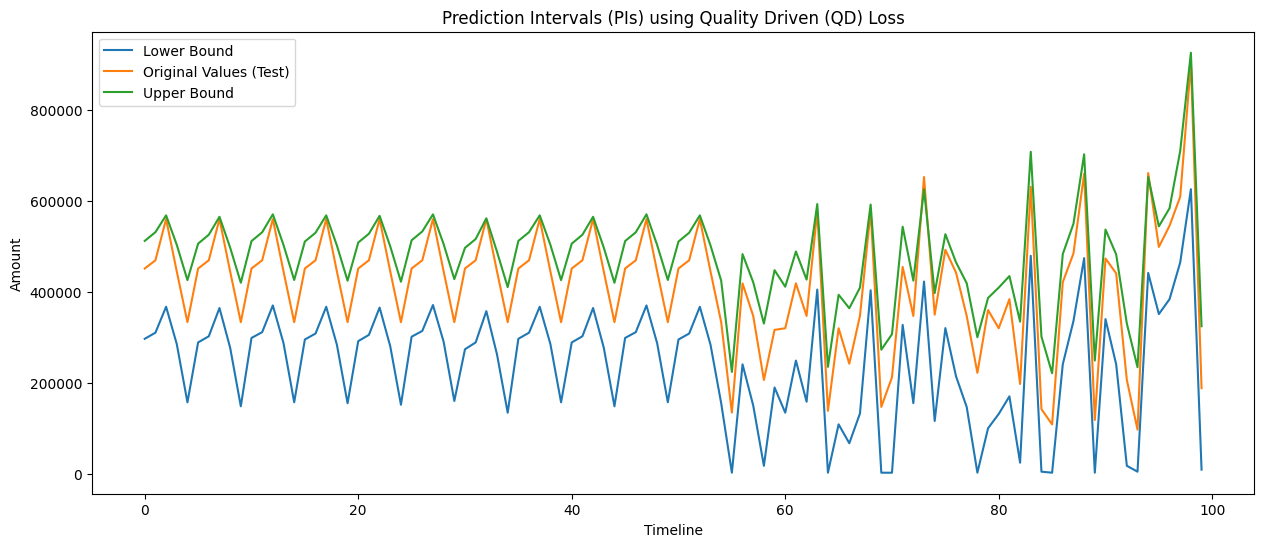

In [50]:
plot_range(y_test_qd, lb_qd, ub_qd, name)

## MVEM

In [52]:
mvem_df = pd.read_csv('../Results/Results_MVEM 2.csv')
mvem_df

,Original,Predicted,Lower Bound,Upper Bound,Outcome
0,445700.0,461648.16,369378.50,553917.80,0
1,155100.0,196166.12,103896.46,288435.78,0
2,213800.0,226193.75,133924.10,318463.40,0
3,293600.0,349797.38,257527.72,442067.03,0
4,687300.0,625863.60,533593.94,718133.30,0
...,...,...,...,...,...
4432,498300.0,494549.06,402279.40,586818.75,0
4433,544800.0,524003.20,431733.53,616272.90,0
4434,608600.0,693523.50,601253.80,785793.20,0
4435,902500.0,852043.00,759773.30,944312.70,0


In [54]:
mvem_df['Outcome'].value_counts(normalize=True)

0    0.957404
1    0.042596
Name: Outcome, dtype: float64

In [55]:
new_mvem = get_new_df(mvem_df)

In [56]:
a = get_picp_mpiw(new_mvem)
print('\nPICP: ', a[0])
print('MPIW: ', a[1], '\n')


PICP:  0.9574036511156186
MPIW:  180972.45326800822 



In [57]:
# l1 = int(len(indian_df) * 0.65)
# D1, D2 = indian_df.loc[:l1, :], indian_df.loc[l1:, :]

# num_features = 32

# D1_targets = D1.iloc[:, num_features:]
# D2_targets = D2.iloc[:, num_features:]



l1 = int(len(indian_df) * 0.65)
D1, D2 = indian_df.loc[:l1, :], indian_df.loc[l1:, :]

l2 = l1 + int(len(D2) * 0.7)

D2_train, D2_val = D2.loc[l1:l2, :], D2.loc[l2:, :]

num_features = 32

D1_features = D1.iloc[:, :num_features]
D2_features = D2.iloc[:, :num_features]

D1_targets = D1.iloc[:, num_features:]
D2_targets = D2.iloc[:, num_features:]

D2_train_features = D2_train.iloc[:, :num_features]
D2_train_targets = D2_train.iloc[:, num_features:]

D2_val_features = D2_val.iloc[:, :num_features]
D2_val_targets = D2_val.iloc[:, num_features:]

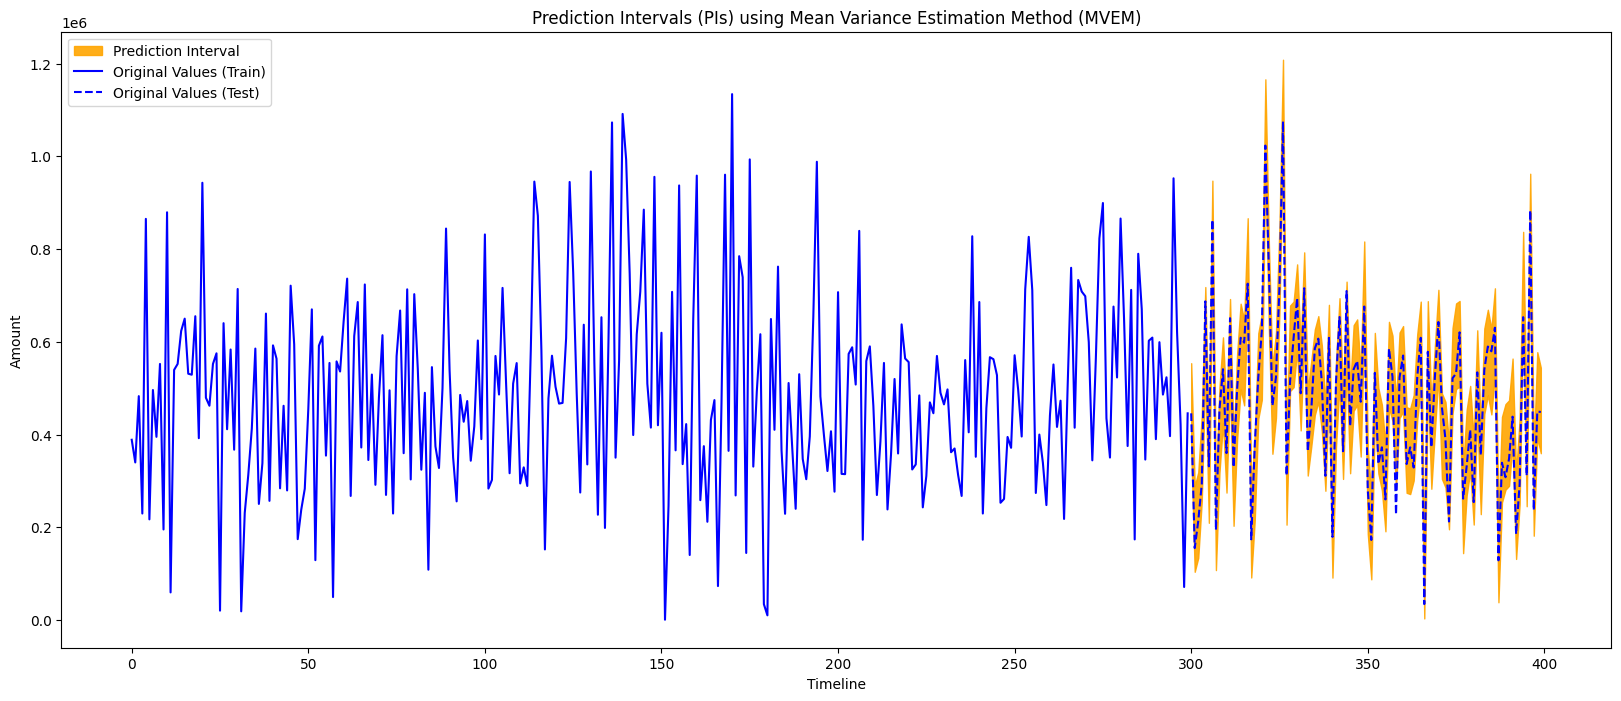

In [58]:
lb_mvem = np.array(new_mvem['Lower Bound'])
ub_mvem = np.array(new_mvem['Upper Bound'])
name = 'Mean Variance Estimation Method (MVEM)'

plot(D1_targets, D2_targets, lb_mvem, ub_mvem, name)

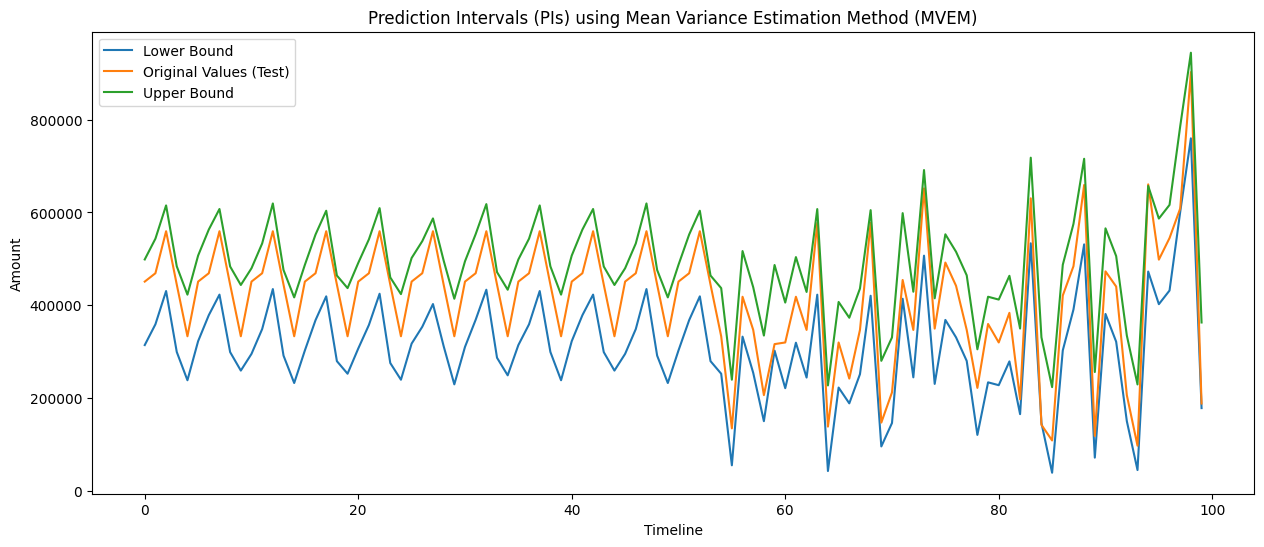

In [59]:
plot_range( D2_targets, lb_mvem, ub_mvem, name)


## Quantile Regression

In [65]:
quant_df = pd.read_csv('../Results/Results_Quant_Reg 2.csv')

In [66]:
quant_df['Outcome'].value_counts(normalize=True)

0    0.957791
1    0.042209
Name: Outcome, dtype: float64

In [67]:
new_quant = get_new_df(quant_df)

In [68]:
a = get_picp_mpiw(new_quant)
print('\nPICP: ', a[0])
print('MPIW: ', a[1], '\n')


PICP:  0.9577909270216962
MPIW:  687398.7052525838 



C:\Users\HP\AppData\Local\Temp\ipykernel_11368\2898526384.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(range(300, 400), y_test[:test_len], color='blue', zorder=2, ls='--', label = 'Original Values (Test)')


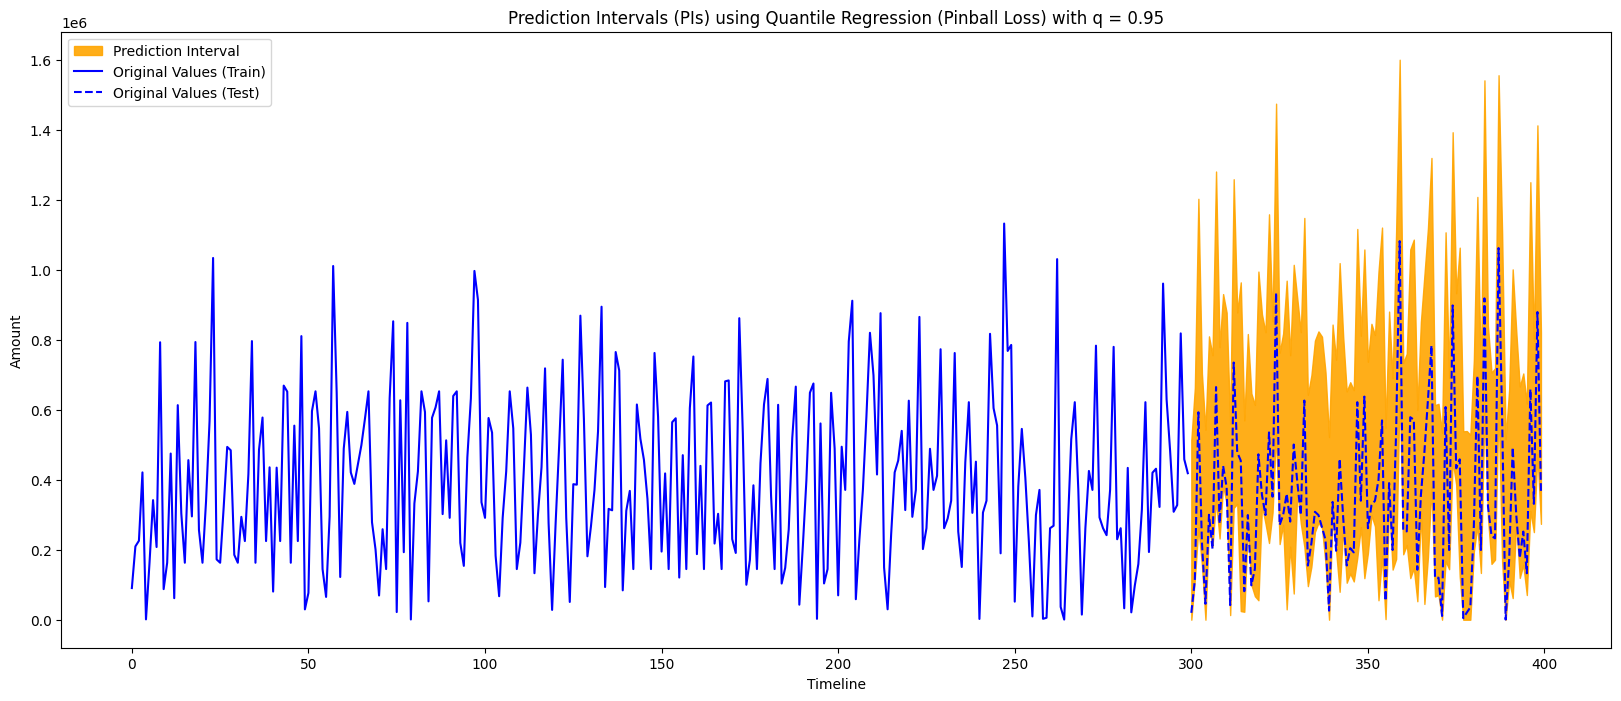

In [69]:
lb_qr = np.array(new_quant['Lower Bound'])
ub_qr = np.array(new_quant['Upper Bound'])
name = 'Quantile Regression (Pinball Loss) with q = 0.95'

plot(y_train_qd, y_test_qd, lb_qr, ub_qr, name)

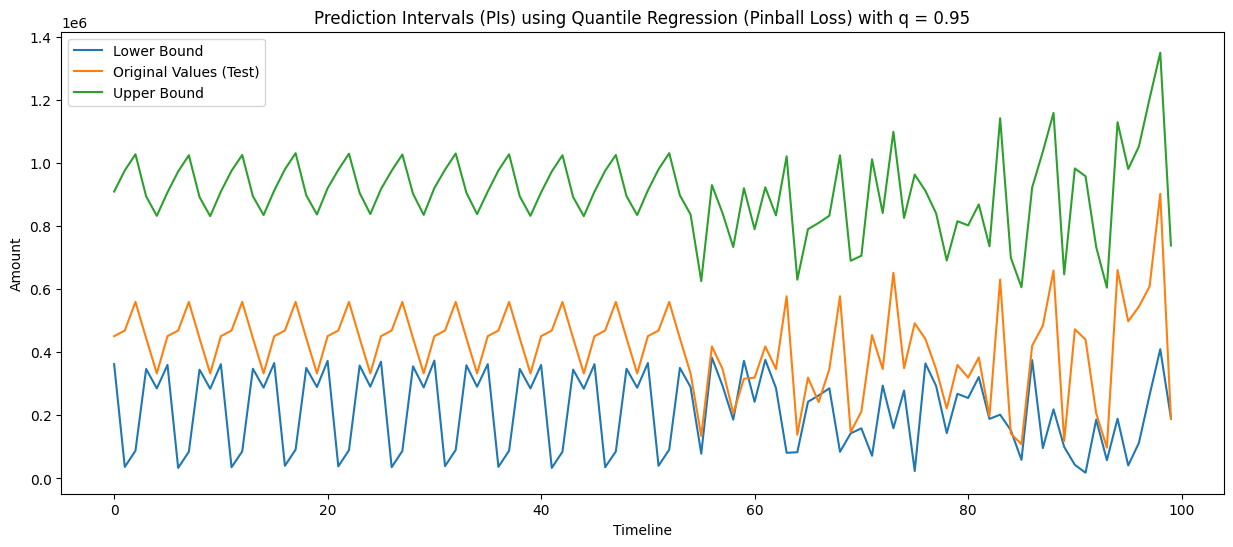

In [70]:

plot_range(y_test_qd, lb_qr, ub_qr, name)


## TUBE Loss

In [79]:
tube_df = pd.read_csv('../Results/Results_TUBE 4.csv')
tube_df

,Original,Predicted,Lower Bound,Upper Bound,Outcome
0,19700.0,4150.3125,-132082.250,140382.88,0
1,113500.0,149339.6600,44679.656,253999.66,0
2,593300.0,668623.5600,548659.400,788587.75,0
3,221600.0,194402.3100,101366.280,287438.34,0
4,45500.0,25104.1880,-108714.250,158922.62,0
...,...,...,...,...,...
2530,498300.0,476674.6000,415537.000,537812.20,0
2531,544800.0,503909.3400,428358.060,579460.60,0
2532,608600.0,634842.0600,518848.400,750835.75,0
2533,902500.0,829337.4400,693777.250,964897.60,0


In [80]:
tube_df['Outcome'].value_counts(normalize=True)


0    0.952268
1    0.047732
Name: Outcome, dtype: float64

In [81]:
new_tube = get_new_df(tube_df)


In [82]:
a = get_picp_mpiw(new_tube)
print('\nPICP: ', a[0])
print('MPIW: ', a[1], '\n')


PICP:  0.9522682445759368
MPIW:  176289.9455334431 



C:\Users\HP\AppData\Local\Temp\ipykernel_11368\2898526384.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(range(300, 400), y_test[:test_len], color='blue', zorder=2, ls='--', label = 'Original Values (Test)')


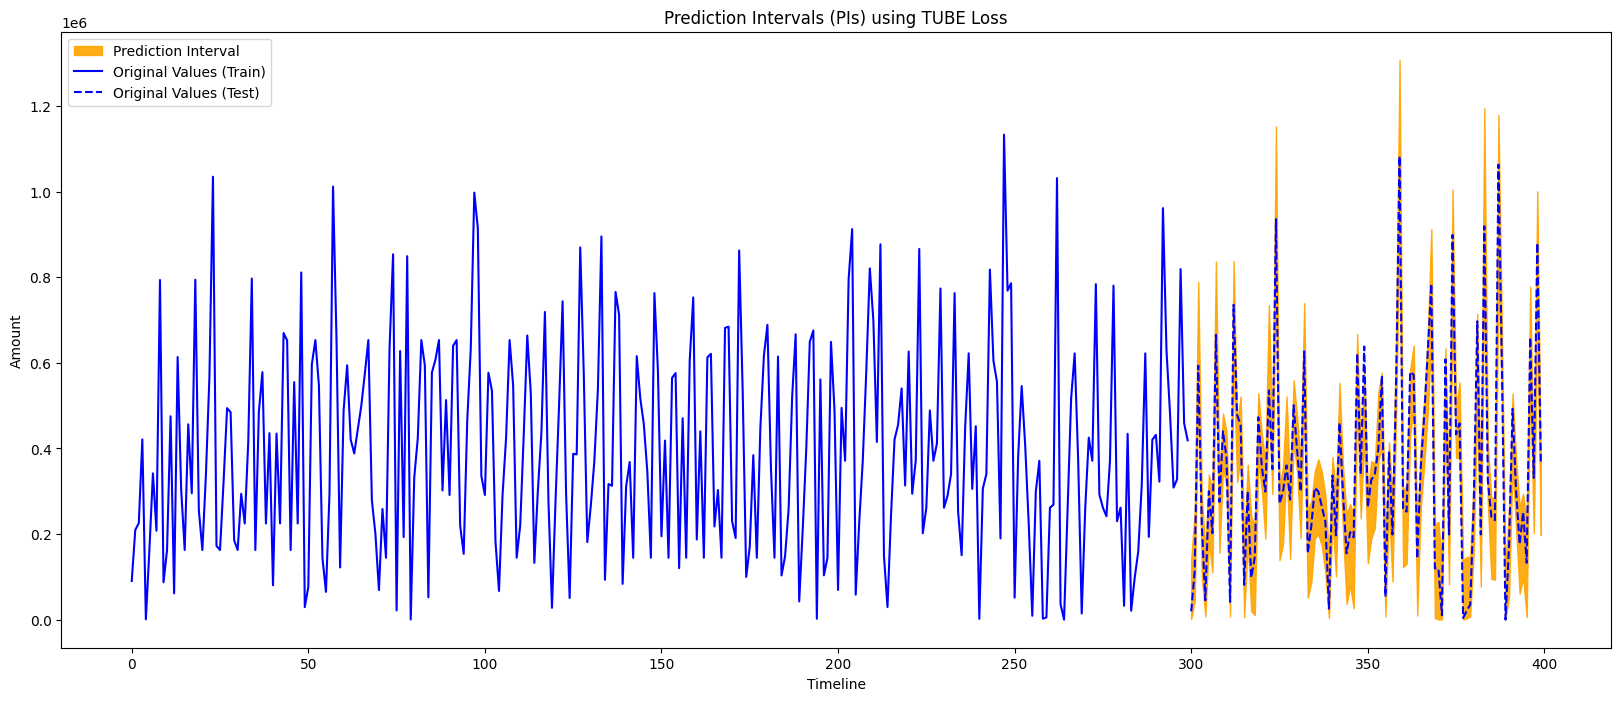

In [85]:
lb_tube = np.array(tube_df['Lower Bound'])
ub_tube = np.array(tube_df['Upper Bound'])
name = 'TUBE Loss'

plot(y_train_qd, y_test_qd, lb_tube, ub_tube, name)

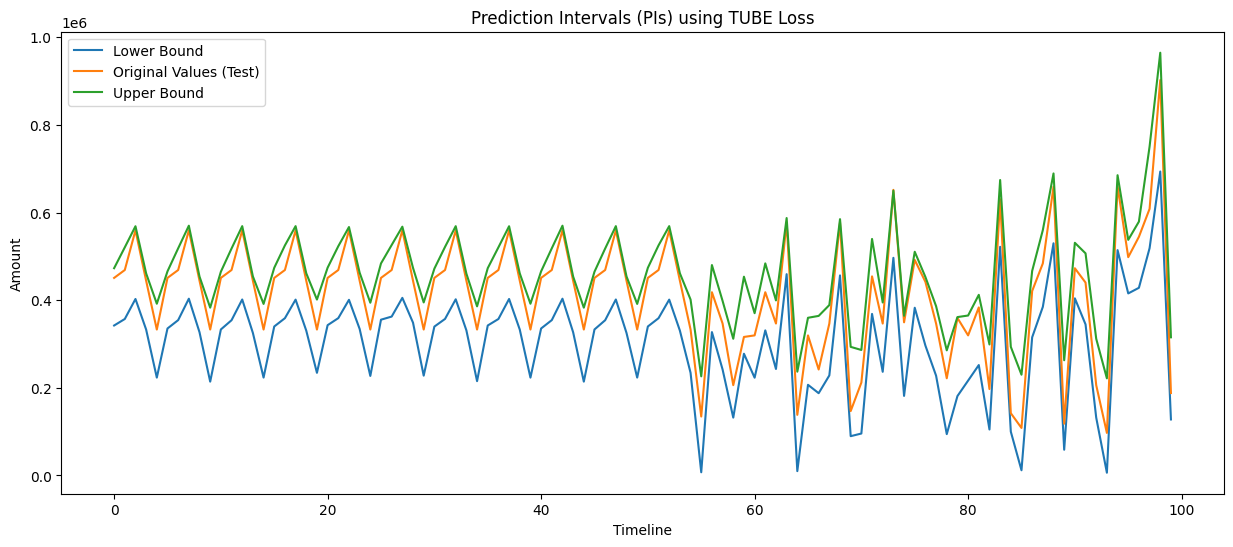

In [86]:
plot_range(y_test_qd, lb_tube, ub_tube, name)